In [1]:
from pathlib import Path

import fig04to05 as nb
import hcp_utils as hcp
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nilearn import plotting

from fmri_timescales import timescale_utils

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
# !! optional: run this code block to refit LLS and NLS estimators, requires full HCP 7T dataset !! #

# set paths to input HCP dataset (if available), output directory
input_path = Path("/Volumes/griegner/datasets/hcp/rawdata7T")
output_path = Path("/Volumes/griegner/datasets/hcp/timescales7T")

# initialize estimators
n_timepoints = 3600
var_n_lags = int(0.75 * n_timepoints ** (1 / 3))  # (Stock and Watson, 2015)
lls = timescale_utils.LLS(var_estimator="newey-west", var_n_lags=var_n_lags, n_jobs=-2)
nls = timescale_utils.NLS(var_estimator="newey-west", var_n_lags=12, acf_n_lags=120, n_jobs=-2)

# re-fit estimators if full dataset available
if len(list(input_path.rglob("*.dtseries.nii"))) == 707:
    nb.fit_timescale_models(input_path, output_path, lls, nls)

In [3]:
# !! else: load intermediate subject-level estimates !! #

# timescale estimates, newey-west standard errors, t-statistics, relative standard errors

lls_ = {
    "tau": np.load("data/nsubjects-180_nregions-91282_estimator-lls_tau.npy").astype(np.float32),
    "se(tau)": np.load("data/nsubjects-180_nregions-91282_estimator-lls_se.npy").astype(np.float32),
}
lls_["tau_N"] = lls_["tau"].mean(axis=0)
lls_["se(tau_N)"] = nb.se_decomposition(lls_["se(tau)"], lls_["tau"])
lls_["tstat_N"] = (lls_["tau_N"] - 0.5) / lls_["se(tau_N)"]
lls_["rse_N"] = lls_["se(tau_N)"] / lls_["tau_N"]

nls_ = {
    "tau": np.load("data/nsubjects-180_nregions-91282_estimator-nls_tau.npy").astype(np.float32),
    "se(tau)": np.load("data/nsubjects-180_nregions-91282_estimator-nls_se.npy").astype(np.float32),
}
nls_["tau_N"] = nls_["tau"].mean(axis=0)
nls_["se(tau_N)"] = nb.se_decomposition(nls_["se(tau)"], nls_["tau"])
nls_["tstat_N"] = (nls_["tau_N"] - 0.5) / nls_["se(tau_N)"]
nls_["rse_N"] = nls_["se(tau_N)"] / nls_["tau_N"]

print("LLS + NLS column names: ", *lls_.keys(), sep="  ")

LLS + NLS column names:   tau  se(tau)  tau_N  se(tau_N)  tstat_N  rse_N


cbar = 0-2.7


(-60.0, 27.0)

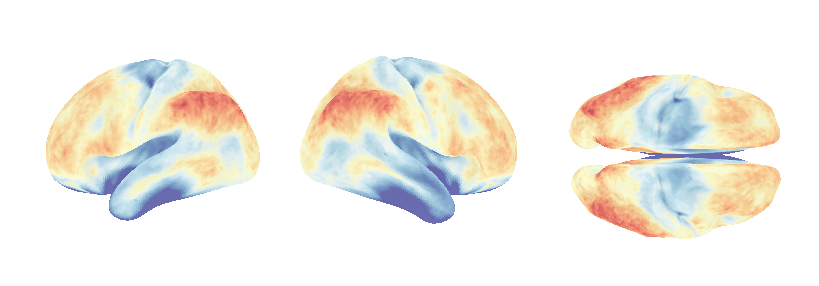

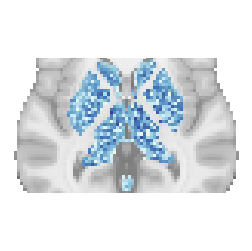

In [4]:
# !! make fig05-c: modify code block to plot all other panels !! #


# subset grayordinates into surface vertices and subcortex voxels
axis = nib.cifti2.load("data/nregions-300_cifti.dlabel.nii").header.get_axis(1)
surface = hcp.cortex_data(lls_["tstat_N"])
volume = nb.cifti_to_volume(lls_["tstat_N"], axis)
vmax = nb.get_vmax(hcp.cortex_data(lls_["tstat_N"]), hcp.cortex_data(nls_["tstat_N"]))
print(f"cbar = 0-{vmax}")

# plot surface
fig, axs = plt.subplots(ncols=3, figsize=(8, 3), subplot_kw=dict(projection="3d"))
fig.tight_layout(pad=0)

kwargs = dict(
    bg_map=hcp.mesh.sulc,
    bg_on_data=True,
    darkness=0.25,
    cmap="RdYlBu_r",
    colorbar=False,
    vmin=0,
    vmax=vmax,
)

plotting.plot_surf(hcp.mesh.inflated, surface, axes=axs[0], view="lateral", hemi="left", **kwargs)
plotting.plot_surf(hcp.mesh.inflated, surface, axes=axs[1], view="lateral", hemi="right", **kwargs)
plotting.plot_surf(hcp.mesh.inflated, surface, axes=axs[2], view="dorsal", **kwargs)


# plot volume
fig, ax = plt.subplots(figsize=(3, 3))
plot = plotting.plot_stat_map(
    volume,
    axes=ax,
    display_mode="z",
    cut_coords=[0],
    black_bg=False,
    annotate=False,
    colorbar=False,
    cmap="RdYlBu_r",
    vmax=vmax,
    symmetric_cbar=False,
)

plot.axes[0].ax.set_xlim(-75, 75)
plot.axes[0].ax.set_ylim(-60, 27)